# IV - Transferencia de Aprendizaje (a)

## Importar librerias

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar100

## Parametros de entrenamiento

In [3]:
lr = 1.0
epochs = 5
batch_size = 32
np.random.seed(14)

## Cargar y visualizar el dataset

In [4]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
n_classes = np.max(np.unique(y_train)) + 1

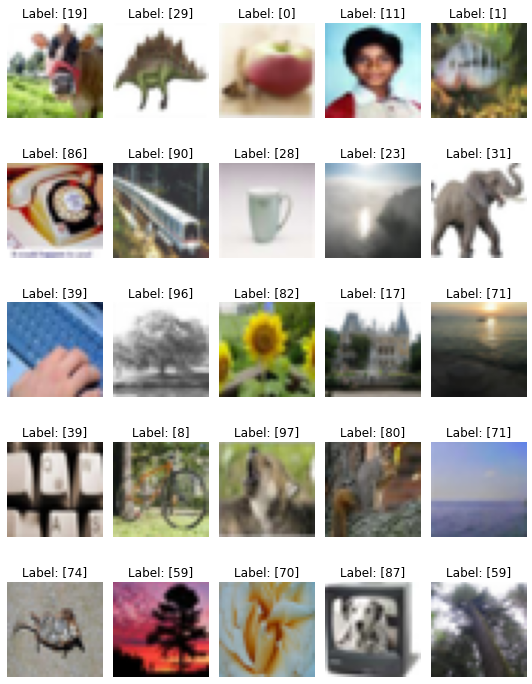

In [5]:
num = 25
images = x_train[:num]
labels = y_train[:num]
num_row = 5
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
    ax.axis('off')
plt.tight_layout()
plt.show()

## Preparacion de los datos

In [6]:
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [7]:
x_train.shape

(50000, 32, 32, 3)

In [8]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes) #one-hot encoding

In [9]:
steps_per_epoch = int(round(x_train.shape[0]/batch_size))

## Aumentacion de los datos

In [10]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

datagen.fit(x_train)

## Crear el modelo

In [12]:
# ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [13]:
for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [15]:
model = Sequential()
model.add(Input(shape=x_train.shape[1:]))
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))

In [16]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc', 'mse'])
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_3 (UpSampling2 (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

## Entrenar el modelo

In [15]:
start_time = time.time()
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

history = model.fit(x=x_train,
                    y=y_train,
#                     train_generator,
#                     steps_per_epoch=steps_per_epoch,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=5,
                    shuffle=True,
                    verbose=1)

end_time = time.time()

print('\nElapsed Convolutional Model training time: {:.5f} seconds'.format(end_time-start_time))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 1142s 23ms/sample - loss: 1.7130 - acc: 0.5468 - mean_squared_error: 0.0059 - val_loss: 0.9377 - val_acc: 0.7181 - val_mean_squared_error: 0.0038
Epoch 2/5
50000/50000 [==============================] - 1133s 23ms/sample - loss: 0.9804 - acc: 0.7109 - mean_squared_error: 0.0040 - val_loss: 0.7937 - val_acc: 0.7640 - val_mean_squared_error: 0.0033
Epoch 3/5
50000/50000 [==============================] - 1132s 23ms/sample - loss: 0.8099 - acc: 0.7536 - mean_squared_error: 0.0034 - val_loss: 0.7582 - val_acc: 0.7711 - val_mean_squared_error: 0.0032
Epoch 4/5
50000/50000 [==============================] - 1132s 23ms/sample - loss: 0.7181 - acc: 0.7785 - mean_squared_error: 0.0031 - val_loss: 0.7474 - val_acc: 0.7758 - val_mean_squared_error: 0.0031
Epoch 5/5
50000/50000 [==============================] - 1132s 23ms/sample - loss: 0.6517 - acc: 0.7977 - mean_squared_error: 0.0028 - val

## Guardar el modelo

In [16]:
model.save('./src/ResNet50_cifar100.h5')

In [17]:
history.history.keys()

dict_keys(['loss', 'acc', 'mean_squared_error', 'val_loss', 'val_acc', 'val_mean_squared_error'])